The dataset provided contains user interaction metrics, demographic profiles, marketing channel exposure, campaign variants, and behavioral signals such as conversion and retention. Your organization is primarily interested in understanding what drives successful conversions and long-term user engagement across different marketing touchpoints. It has asked you to explore whether campaign strategies, personalization, and localization efforts are yielding significant performance differences.

The dataset, 'marketing_new.csv', was obtained from internal campaign tracking records. It includes variables such as marketing channel, user language preferences, age group segmentation, conversion outcomes, retention flags, and A/B test assignment. Several features have been engineered to support this analysis:

'converted': indicates whether the user responded positively to the campaign

'is_retained': denotes sustained engagement over time

'is_correct_lang': captures alignment between preferred and displayed language

'variant': categorizes users into control or personalized messaging groups

For this project, the dataset was further prepared to reflect the presence of campaign conversion signals and the quality of language targeting. Our goal is to identify high-performing strategies and uncover improvement opportunities in campaign design.

| Column             | Description                                                                 |
|--------------------|-----------------------------------------------------------------------------|
| date_served        | The date the marketing message was shown to the user                        |
| date_subscribed    | The date the user subscribed to the service                                 |
| date_canceled      | The date the user canceled the service (if applicable)                      |
| marketing_channel  | The source/channel through which the user saw the campaign (e.g., Email)    |
| variant            | A/B test assignment — either Control or Personalization                     |
| age_group          | The user’s age category (e.g., 19–24, 25–30)                                |
| language_preferred | The language the user prefers for consuming content                         |
| language_displayed | The language that was actually shown in the campaign material               |
| is_correct_lang    | Whether the displayed language matched the user’s preference (Yes/No)       |
| converted          | Whether the user subscribed after seeing the campaign (1 = Yes, 0 = No)     |
| is_retained        | Whether the user remained subscribed for the desired retention period        |
| campaign_duration  | Number of days between subscription and cancellation (if applicable)        |
| day_of_week        | Weekday name extracted from date_served for timing analysis                 |


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings ('ignore')
df = pd.read_csv('marketing_new.csv')

## Examining the data: Ensure the validity of the dataset

In [26]:
df.head()

,Unnamed: 0,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,DoW,channel_code,is_correct_lang
0,0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes
1,1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes
2,2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes
3,3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes
4,4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           10037 non-null  int64  
 1   user_id              10037 non-null  object 
 2   date_served          10021 non-null  object 
 3   marketing_channel    10022 non-null  object 
 4   variant              10037 non-null  object 
 5   converted            10037 non-null  bool   
 6   language_displayed   10037 non-null  object 
 7   language_preferred   10037 non-null  object 
 8   age_group            10037 non-null  object 
 9   date_subscribed      1856 non-null   object 
 10  date_canceled        577 non-null    object 
 11  subscribing_channel  1856 non-null   object 
 12  is_retained          10037 non-null  bool   
 13  DoW                  1856 non-null   float64
 14  channel_code         1856 non-null   float64
 15  is_correct_lang      10037 non-null 

In [28]:
df.describe()

,Unnamed: 0,DoW,channel_code
count,10037.00000,1856.000000,1856.000000
mean,5018.00000,2.529634,2.631466
std,2897.57666,1.937900,1.211340
min,0.00000,0.000000,1.000000
25%,2509.00000,1.000000,2.000000
50%,5018.00000,2.000000,2.000000
75%,7527.00000,4.000000,3.000000
max,10036.00000,6.000000,5.000000


In [29]:
df.isnull().sum()

Unnamed: 0                0
user_id                   0
date_served              16
marketing_channel        15
variant                   0
converted                 0
language_displayed        0
language_preferred        0
age_group                 0
date_subscribed        8181
date_canceled          9460
subscribing_channel    8181
is_retained               0
DoW                    8181
channel_code           8181
is_correct_lang           0
dtype: int64

## Data Cleaning

In [38]:
# Convert dates
date_cols = ['date_served', 'date_subscribed', 'date_canceled']
df[date_cols] = df[date_cols].apply(pd.to_datetime, errors='coerce')
df[date_cols].dtypes

date_served        datetime64[ns]
date_subscribed    datetime64[ns]
date_canceled      datetime64[ns]
dtype: object

In [39]:
# Fill missing marketing_channel (optional: or drop)
df['marketing_channel'].fillna('Unknown', inplace=True)
print("\nMissing values in 'marketing_channel' after filling:")
print(df['marketing_channel'].isnull().sum())


Missing values in 'marketing_channel' after filling:
0


In [40]:
# Create campaign_duration
df['campaign_duration'] = (df['date_canceled'] - df['date_subscribed']).dt.days
print("\nSample campaign_duration values:")
print(df[['date_subscribed', 'date_canceled', 'campaign_duration']].head(10))


Sample campaign_duration values:
  date_subscribed date_canceled  campaign_duration
0      2018-01-01           NaT                NaN
1      2018-01-01           NaT                NaN
2      2018-01-01           NaT                NaN
3      2018-01-01           NaT                NaN
4      2018-01-01           NaT                NaN
5      2018-01-01           NaT                NaN
6      2018-01-01           NaT                NaN
7      2018-01-01           NaT                NaN
8      2018-01-01           NaT                NaN
9      2018-01-01           NaT                NaN


In [41]:
# Boolean conversion
df['is_correct_lang'] = df['is_correct_lang'].map({'Yes': True, 'No': False})
print("\nUnique values in 'is_correct_lang' after conversion:")
print(df['is_correct_lang'].unique())


Unique values in 'is_correct_lang' after conversion:
[nan]


## Exploratory Data Analysis (EDA)

In [42]:
# Daily marketing reach by channel
daily_users = df.groupby(['date_served'])['user_id'].nunique()
daily_users.head()

date_served
2018-01-01    362
2018-01-02    374
2018-01-03    348
2018-01-04    323
2018-01-05    319
Name: user_id, dtype: int64

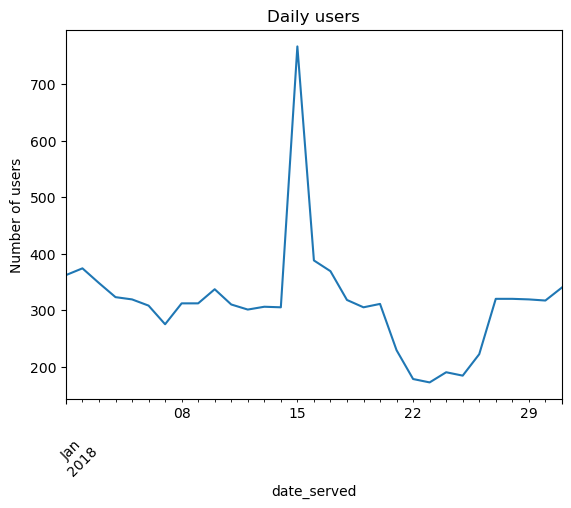

In [43]:
# Visualizing daily marketing reach
daily_users.plot()
plt.title('Daily users')
plt.ylabel('Number of users')
plt.xticks(rotation=45)
plt.show()

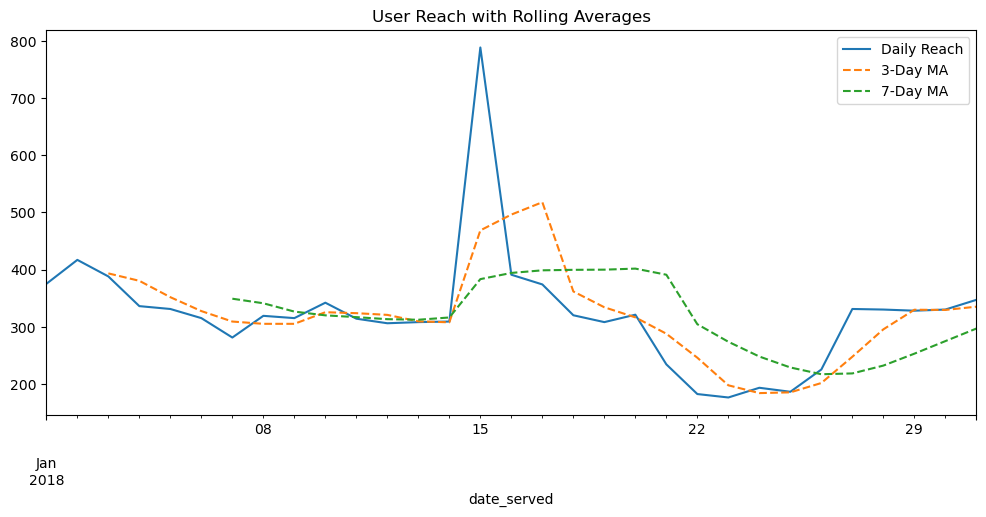

In [45]:
# Add 3-day and 7-day rolling averages
rolling_avg_3 = daily_reach.rolling(3).mean()
rolling_avg_7 = daily_reach.rolling(7).mean()

plt.figure(figsize=(12,5))
daily_reach.plot(label='Daily Reach')
rolling_avg_3.plot(label='3-Day MA', linestyle='--')
rolling_avg_7.plot(label='7-Day MA', linestyle='--')
plt.legend()
plt.title('User Reach with Rolling Averages')
plt.show()

**Key Finding:** There was a major spike in daily user reach on January 15th, with over 800 users served more than double the usual volume

**Short-Term Trends:**
The 3-day moving average highlights quick bursts of activity, especially around the 15th.
The 7-day moving average shows a sustained uptick even after the spike, signaling positive campaign momentum.

This anomaly likely correlates with a high-impact campaign event—such as a paid promotion, content release, or channel push. However, it wasn’t sustained, suggesting a need to investigate retention and conversion effectiveness during that surge.

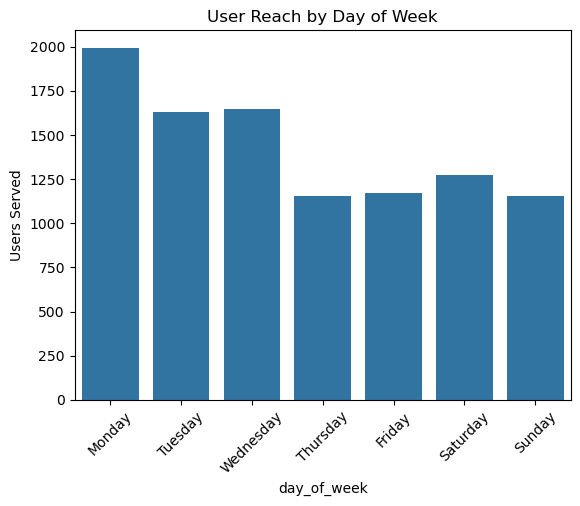

In [46]:
# Convert date to weekday name
df['day_of_week'] = df['date_served'].dt.day_name()
dow_reach = df['day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

sns.barplot(x=dow_reach.index, y=dow_reach.values)
plt.title('User Reach by Day of Week')
plt.xticks(rotation=45)
plt.ylabel('Users Served')
plt.show()

Weekday Performance Insight: User reach peaked on Monday, suggesting strong engagement at the start of the week. Sunday saw the lowest activity, with minimal campaign traction. Mondays is optimal for launching or amplifying marketing efforts, while Sunday content may require reevaluation or strategic shifts.

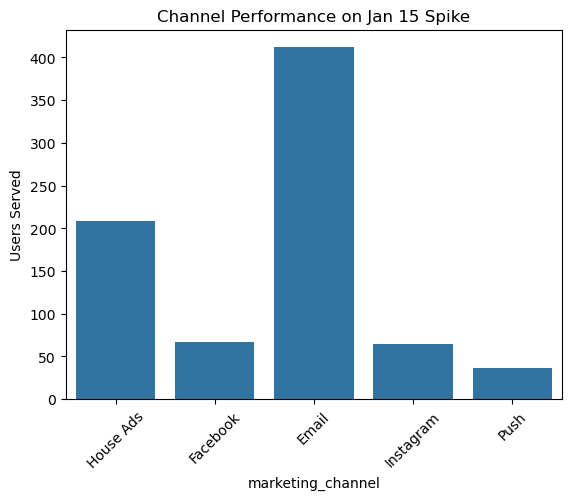

In [47]:
# Extract the spike day
peak_day = pd.to_datetime('2018-01-15')
df_peak = df[df['date_served'] == peak_day]

# Breakdown by channel
sns.countplot(x='marketing_channel', data=df_peak)
plt.title('Channel Performance on Jan 15 Spike')
plt.xticks(rotation=45)
plt.ylabel('Users Served')
plt.show()

On the spike day of January 15, **Email** campaigns dominated user reach, serving over 400 users—twice that of House Ads. Other channels like Instagram, Facebook, and Push lagged far behind. This highlights Email as the key driver behind the surge, making it a strong candidate for amplification in future campaigns.

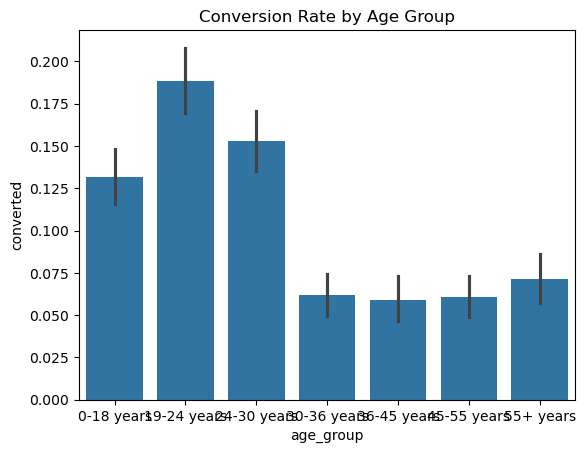

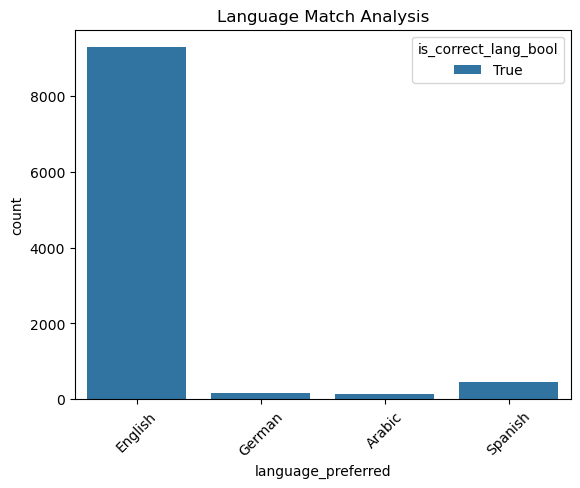

In [66]:
# Age vs Conversion
sns.barplot(x='age_group', y='converted', data=df)
plt.title('Conversion Rate by Age Group')
plt.show()

# Preferred Language vs Correct Display
df['is_correct_lang_bool'] = df['is_correct_lang'] == "No" 
sns.countplot(x='language_preferred', hue='is_correct_lang_bool', data=df) 
plt.title('Language Match Analysis') 
plt.xticks(rotation=45) 
plt.show()

The highest conversion rate comes from the 19–24 age group, followed by 24–30. Users aged 30–36 show the lowest engagement.

English speakers dominate mismatched language cases, signaling a gap between preferred and displayed content—especially for Spanish speakers too. Targeted language optimization could improve conversions.

In [73]:
# Conversion Rate: % of users who saw the ads and subsequently became subscribers
subscribers = df [df ['converted'] == True]['user_id'].nunique()
total = df ['user_id'].nunique()
conversion_rate = subscribers/total
print(round(conversion_rate*100,2),"%")

14.09 %


In [74]:
# Retention Rate: % of users remain subscribers
total_subscribers = df [df ['converted'] == True]['user_id'].nunique()
retained = df [(df ['converted'] == True) &
    (df ['is_retained'] == True)]['user_id'].nunique()
retention_rate = retained/total_subscribers
print(round(retention_rate*100, 2), "%")

67.57 %


In [75]:
# Customer Segmentation
# Comparing language conversion rate
english_speakers = df[df ['language_displayed'] == 'English']
total = english_speakers['user_id'].nunique()
subscribers = english_speakers[english_speakers['converted'] == True]['user_id'].nunique()
conversion_rate = subscribers/total
print('English speaker conversion rate:', round(conversion_rate*100,2), '%')

English speaker conversion rate: 13.13 %


In [76]:
total = df.groupby(['language_displayed'])['user_id'].nunique()
subscribers = df[df['converted'] == True].groupby(['language_displayed'])['user_id'].nunique()
language_conversion_rate = subscribers/total
print(round(language_conversion_rate*100,2),"%")

language_displayed
Arabic     50.00
English    13.13
German     71.62
Spanish    20.00
Name: user_id, dtype: float64 %


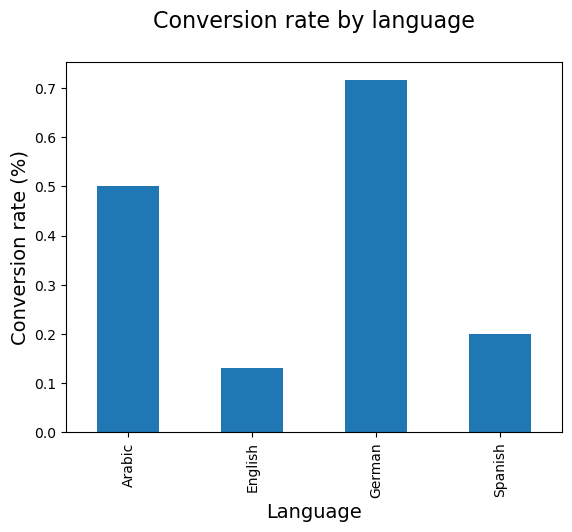

In [72]:
# Visualize conversion rate by language
language_conversion_rate.plot (kind ='bar')
plt.title('Conversion rate by language\n', size = 16)
plt.xlabel('Language', size = 14)
plt.ylabel('Conversion rate (%)', size = 14)
plt.show()


English speakers convert below average at 13.13%, while German speakers show standout performance with a 71.62% conversion rate.

There’s a clear mismatch between the language displayed (often English) and the user’s preferred language (Spanish, Arabic, German). This disconnect likely contributes to lower conversion rates among non-English speakers—especially evident in the underperformance of Spanish and English campaigns.

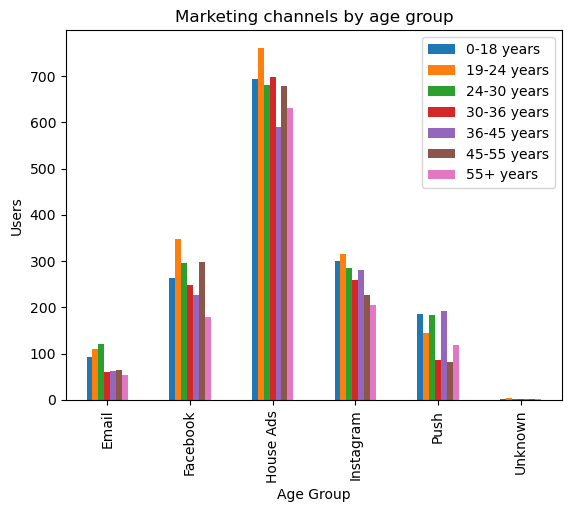

In [79]:
# Visualize Marketing channels across age groups
channel_age = df.groupby(['marketing_channel', 'age_group'])\
                                ['user_id'].count()
channel_age_df = pd.DataFrame(channel_age.unstack(level = 1))
channel_age_df.plot(kind = 'bar')
plt.title('Marketing channels by age group')
plt.xlabel('Age Group')
plt.ylabel('Users')
# Add a legend to the plot
plt.legend(loc = 'upper right', 
           labels = channel_age_df.columns.values)
plt.show()

House Ads are the most popular channel across all age groups—especially among users aged 19–24, followed by 24–30. Facebook and Instagram see strong engagement from younger audiences (primarily under 30). Email and Push are less utilized overall, while the Unknown category shows minimal reach.

## A/B Testing

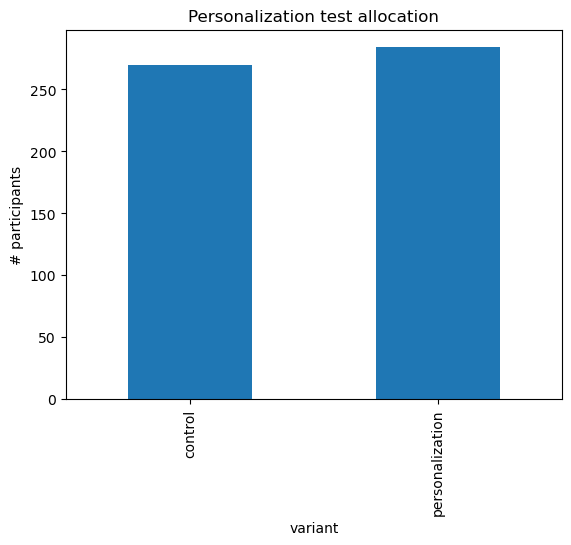

In [84]:
# Test allocation: Ensure the experiments are allocated correctly
# Subset the DataFrame
email = df [df['marketing_channel'] == 'Email']

# Group the email DataFrame by variant 
allocation = email.groupby(['variant'])['user_id'].nunique()

# Plot a bar chart of the test allocation
allocation.plot(kind = 'bar')
plt.title('Personalization test allocation')
plt.ylabel('# participants')
plt.show()

This chart confirms that the Email campaign variants were evenly distributed, with roughly equal participation between Control and Personalization groups

In [81]:
subscribers = email.groupby(['user_id', 
                             'variant'])['converted'].max()
subscribers_df = pd.DataFrame(subscribers.unstack(level=1))
control = subscribers_df['control'].dropna()
personalization = subscribers_df['personalization'].dropna()

print('Control conversion rate:', np.mean(control))
print('Personalization conversion rate:', np.mean(personalization))


Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


**Personalized** email content **outperformed** the control group significantly in driving conversions:

Control conversion rate: 28.15%

Personalization conversion rate: 39.08%

That’s an uplift of nearly 11 percentage points, signaling that tailored messaging can meaningfully boost campaign effectiveness.

In [82]:
def lift(a,b):
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    lift = (b_mean-a_mean)/a_mean
    return str(round(lift*100, 2)) + '%'
print(lift(control, personalization))

38.85%


As you can see, there's a large lift, but are your results statistically significant?

In [83]:
from scipy.stats import ttest_ind
control = np.array(control, dtype=float)
personalization = np.array(personalization, dtype=float)
t = ttest_ind(control, personalization)
print(t)

TtestResult(statistic=np.float64(-2.734329944750507), pvalue=np.float64(0.0064514878446941815), df=np.float64(552.0))


Since the p-value is  below 0.05, we can confidently reject the null hypothesis—meaning the personalization variant had a real impact on conversion rates.

✅ **Key Takeaways:**

Personalized email campaigns achieved a conversion rate of 39.08%, significantly outperforming the control group by ~11 percentage points, with statistical significance (p-value: 0.0064).

Users shown content in their preferred language—especially German and Arabic—converted at dramatically higher rates (up to 71.62%), compared to English.

User reach peaked sharply on Monday, Jan 15, driven by the Email channel. Other weekdays showed stable performance, while Sundays underdelivered.

House Ads performed best across all age groups, while social platforms like Facebook and Instagram attracted younger users.

Overall retention rate stood at 67.57%, suggesting solid post-conversion value and opportunity for remarketing strategies.